<a href="https://colab.research.google.com/github/nikitcha/electricity_rl/blob/master/Power_Zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Imports


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import math
from abc import ABC, abstractmethod
import time
import matplotlib.pyplot as plt

run_test = False
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' \ --port=9090 --no-browser

# Agents library


## Replay Buffer

In [93]:
class ReplayBuffer():
    def __init__(self, capacity, experience):
        '''
        Experience = namedtuple('Experience', field_names=['state', 'action', 'reward','done', 'new_state'])
        '''
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.experience = experience

    def __len__(self):
        return len(self.buffer)

    def append(self, *args):        
        self.buffer.append(self.experience(*args))

    def sample(self, batch_size, cast=None):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        output = zip(*[self.buffer[idx] for idx in indices])
        if cast:
            output = (torch.tensor(t, dtype=dt) for t,dt in zip(output,cast))              
        return output
    
    def replay(self, cast=None):
        indices = np.arange(0, len(self.buffer))
        output = zip(*[self.buffer[idx] for idx in indices])
        if cast:
            output = (torch.tensor(t, dtype=dt) for t,dt in zip(output,cast))         
        return output     

    def empty(self):
        self.buffer = deque(maxlen=self.capacity)

## Q-Table
Q-Learning is direct state-action-value optimization for tabular environments

In [94]:
class QTable():
    def __init__(self, states=16, actions=4, gamma=0.99, alpha=0.1, epsilon=0.9, epsilon_min=0.01, epsilon_decay=2e-6):
        self.table = np.zeros([states, actions])
        self.gamma = gamma
        self.alpha = alpha
        self.action_space = np.arange(0,actions)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def train_net(self, state, next_state, action):
        old_value = self.table[state, action]
        next_max = np.max(self.table[next_state])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.table[state, action] = new_value
        self.epsilon = np.clip(self.epsilon-self.epsilon_decay, self.epsilon_min,1)

    def sample_action(self, state, epsilon=-1):
        eps = self.epsilon if epsilon==-1 else epsilon          
        if random.uniform(0, 1) < eps:
            action = random.choice(self.action_space)
        else:
            action = np.argmax(self.table[state])
        return action

Test on Frozen Lake grid world
<br>https://gym.openai.com/envs/FrozenLake-v0/


In [95]:
if run_test:
    env = gym.make("FrozenLake-v0")
    Q = QTable(states=env.observation_space.n, actions=env.action_space.n)
    print_interval = 1000
    score = []

    for n_epi in range(50000):
        done = False
        state = env.reset()
        score = []
        while not done:
            action = Q.sample_action(state)
            next_state, reward, done, info = env.step(action)
            Q.train_net(state,next_state,action)
            score.append(reward)
            state = next_state
          
        if not n_epi%print_interval:
            print("# of episode: {}, score: {:.1f}, steps: {}".format(n_epi, np.sum(score), len(score)))
    env.close()

## Reinforce
Reinforce algorithm is a direct policy optimization, i.e. find actions that increase the rewards.


In [123]:
class Reinforce(nn.Module):
    def __init__(self, states=4, actions=2,gamma=0.98):
        super(Reinforce, self).__init__()
        self.experience = namedtuple('Experience', field_names=['reward', 'prob'])
        self.memory = ReplayBuffer(10000,self.experience)
        self.gamma = gamma        
        self.fc1 = nn.Linear(states, 256)
        self.fc2 = nn.Linear(256, actions)
        self.optimizer = optim.Adam(self.parameters(), lr=5e-4)
        self.dist = Categorical
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x
      
    def sample_action(self,state):
        prob = self(state)
        m = self.dist(prob)
        return m.sample(), prob

    def train_net(self):
        R = 0
        self.optimizer.zero_grad()
        Rw,Pb = self.memory.replay()
        for ret, prob in zip(Rw[::-1],Pb[::-1]):
            R = ret + self.gamma * R
            loss = -torch.log(prob) * R
            loss.backward()
        self.optimizer.step()
        self.memory.empty()

Check on Cartpole Task

In [97]:
if run_test:
    env = gym.make('CartPole-v1')
    pi = Reinforce()
    score = 0.0
    print_interval = 20
    for n_epi in range(1000):
        s = env.reset()
        done = False
        
        while not done: # CartPole-v1 forced to terminates at 500 step.
            a,prob = pi.sample_action(torch.from_numpy(s).float())
            s_prime, r, done, info = env.step(a.item())
            pi.memory.append(r,prob[a])
            s = s_prime
            score += r
            
        pi.train_net()
        
        if n_epi%print_interval==0 and n_epi!=0:
            print("# of episode :{}, avg score : {}".format(n_epi, score/print_interval))
            score = 0.0
    env.close()


## Actor-Critic
Actor-critic combines ideas from Q-Learning and Policy optimization.
<br>The actor (the policy model) learns to make actions that increase future expected payoff, while the critic learns to predict the expected payoff given the state.

In [98]:
class ActorCritic(nn.Module):
    def __init__(self, states=4, actions=2, gamma=0.98, entropy=0):
        super(ActorCritic, self).__init__()
        self.data = []
        self.gamma = gamma
        self.fc1 = nn.Linear(states,256)
        self.fc_pi = nn.Linear(256,actions)
        self.fc_v = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=2e-4)
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward','done', 'new_state'])
        self.cast = [torch.float, torch.int64, torch.float, torch.float, torch.float]
        self.memory = ReplayBuffer(10000,self.experience)
        self.dist = Categorical
        self.entropy = entropy
        
    def pi(self, x, softmax_dim = 0): # Pi=policy-> Actor
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    
    def v(self, x): # v = Value -> Critic
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
          
    def sample_action(self, state):
        prob = self.pi(state)
        m = Categorical(prob)
        return m.sample().item()

    def train_net(self):
        s, a, r, done, s_prime = self.memory.replay(self.cast)
        [a,done,r] = [torch.reshape(x,[-1,1]) for x in [a,done,r]]
        
        td_target = r + self.gamma * self.v(s_prime) * done
        delta = td_target - self.v(s)

        pi = self.pi(s, softmax_dim=1)
        pi_a = pi.gather(1,a)
        loss = -torch.log(pi_a) * delta.detach() + F.smooth_l1_loss(self.v(s), td_target.detach())
        entropy = -torch.sum(pi*torch.log(pi),dim=1,keepdim=True)
        loss = loss - self.entropy*entropy

        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()     
        self.memory.empty()    

Test on Cartpole

In [99]:
if run_test:
    env = gym.make('CartPole-v1')
    model = ActorCritic()    
    print_interval = 20
    score = 0.0
    n_rollout     = 10        

    for n_epi in range(1000):
        done = False
        s = env.reset()
        while not done:
            for t in range(n_rollout):
                a = model.sample_action(torch.from_numpy(s).float())
                s_prime, r, done, info = env.step(a)
                model.memory.append(s,a,r/100,not done,s_prime)
                
                s = s_prime
                score += r
                
                if done:
                    break                     
            
            model.train_net()
            
        if n_epi%print_interval==0 and n_epi!=0:
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
            score = 0.0
    env.close()

## DQN
DQN is extension of the Q-Table.
<br>It can handle more complext state and action spaces (i.e. not tabular) but it remains state-action-value optimization algorithm (i.e. no policy optimization)
<br> Note: DQNs are notoriously sensitive to hyper-parameters

In [100]:
class Qnet(nn.Module):
    def __init__(self, states=4, actions=2):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(states, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x      

class DQN(nn.Module):
    def __init__(self, states=4, actions=2, batch_size=32, gamma=0.98, eps_end=2e-2, epsilon=0.1, eps_step=1e-4, copy_freq=20):
        super(DQN, self).__init__()
        self.q = Qnet(states, actions)
        self.q_target = Qnet(states, actions)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.parameters(), lr=5e-4)
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward','done', 'new_state'])
        self.cast = [torch.float, torch.int64, torch.float, torch.float, torch.float]
        self.memory = ReplayBuffer(50000,self.experience)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_end = eps_end
        self.eps_step = eps_step
        self.copy_freq = copy_freq
        self.epoch = 0
        self.actions = actions

    def sample_action(self, obs):
        out = self.q(obs)
        coin = random.random()
        if coin < self.epsilon:
            return np.random.randint(0,self.actions)
        else : 
            return out.argmax().item()      

    def train_net(self):
        if len(self.memory)>2000:
            for i in range(10):
                s, a, r, done, s_prime = self.memory.sample(self.batch_size, self.cast)
                [a,done,r] = [torch.reshape(x,[-1,1]) for x in [a,done,r]]

                q_out = self.q(s)
                q_a = q_out.gather(1,a)
                max_q_prime = self.q_target(s_prime).max(1)[0].unsqueeze(1)
                target = r + self.gamma * max_q_prime * done
                loss = F.smooth_l1_loss(q_a, target)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            self.epsilon = np.clip(self.epsilon-self.eps_step,self.eps_end,1)
            self.epoch +=1
            if not self.epoch%self.copy_freq:
                self.q_target.load_state_dict(self.q.state_dict())

Check on Cartpole

In [101]:
if run_test:
    env = gym.make('CartPole-v1')
    dqn = DQN()
    print_interval = 20
    score = 0.0  

    for n_epi in range(2000):
        s = env.reset()
        done = False

        while not done:
            a = dqn.sample_action(torch.from_numpy(s).float())      
            s_prime, r, done, info = env.step(a)
            dqn.memory.append(s,a,r/100,not done,s_prime)
            s = s_prime

            score += r
            if done:
                break
            
        dqn.train_net()

        if n_epi%print_interval==0 and n_epi!=0:
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(n_epi, score/print_interval, len(dqn.memory), dqn.epsilon*100))
            score = 0.0
    env.close()

## PPO
Proximal Policy Optimization is an extension to Actor-Critic.
<br> The differences lie in the way the advantage is calculated during training as well as the speed at which the policy is allowed to change.
<br> For a good explanation see: https://www.youtube.com/watch?v=5P7I-xPq8u8


In [102]:
class PPO(nn.Module):
    def __init__(self, state=4, action=2,K_epoch=3,gamma=0.98,eps_clip=0.1,lmbda=0.95):
        super(PPO, self).__init__()
        self.gamma         = gamma
        self.lmbda         = lmbda
        self.eps_clip      = eps_clip
        self.K_epoch       = K_epoch
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward','done', 'new_state', 'prob'])
        self.cast = [torch.float, torch.int64, torch.float, torch.float, torch.float, torch.float]
        self.memory = ReplayBuffer(50000,self.experience)

        self.fc1   = nn.Linear(state,256)
        self.fc_pi = nn.Linear(256,action)
        self.fc_v  = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=5e-4)

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
      
    def sample_action(self, obs):
        prob = model.pi(obs)
        m = Categorical(prob)
        a = m.sample().item()
        return a, prob[a].item()

    def train_net(self):
        s, a, r, done, s_prime, prob_a = self.memory.replay(self.cast)
        [a,done,r,prob_a] = [torch.reshape(x,[-1,1]) for x in [a,done,r,prob_a]]

        for i in range(self.K_epoch):
            td_target = r + self.gamma * self.v(s_prime) * done
            delta = td_target - self.v(s)
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = self.gamma * self.lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        self.memory.empty()

Check on Cartpole

In [103]:
if run_test:
    env = gym.make('CartPole-v1')
    model = PPO()
    score = 0.0
    print_interval = 20
    T_horizon     = 20

    for n_epi in range(1000):
        s = env.reset()
        done = False
        while not done:
            for t in range(T_horizon):
                a, prob = model.sample_action(torch.from_numpy(s).float())
                s_prime, r, done, info = env.step(a)
                model.memory.append(s, a, r/100.0, not done, s_prime, prob)
                s = s_prime

                score += r
                if done:
                    break

            model.train_net()

        if n_epi%print_interval==0 and n_epi!=0:
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
            score = 0.0

    env.close()

## SAC-Continuous
Soft Actor-Critic is another extension of basic Actor-Critic which is designed for continuous action spaces.



In [104]:
class QNet(nn.Module):
    def __init__(self, states=3, actions=1, learning_rate=0.001, tau=0.01):
        super(QNet, self).__init__()
        self.tau = tau
        self.fc_s = nn.Linear(states, 64)
        self.fc_a = nn.Linear(actions,64)
        self.fc_cat = nn.Linear(128,32)
        self.fc_out = nn.Linear(32,actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        cat = torch.cat([h1,h2], dim=1)
        q = F.relu(self.fc_cat(cat))
        q = self.fc_out(q)
        return q

    def train_net(self, target, mini_batch):
        s, a, r, done, s_prime = mini_batch
        loss = F.smooth_l1_loss(self.forward(s, a) , target)
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

    def soft_update(self, net_target):
        for param_target, param in zip(net_target.parameters(), self.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

class PolicyNet(nn.Module):
    def __init__(self, states=3, actions=1, learning_rate=0.0005, init_alpha=0.01, target_entropy=-1., lr_alpha=1e-3, activation=torch.tanh):
        super(PolicyNet, self).__init__()
        self.init_alpha = init_alpha
        self.target_entropy = target_entropy
        self.fc1 = nn.Linear(states, 128)
        self.fc_mu = nn.Linear(128,actions)
        self.fc_std  = nn.Linear(128,actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        self.log_alpha = torch.tensor(np.log(self.init_alpha))
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], lr=lr_alpha)
        self.activation = activation

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action)
        real_action = self.activation(action)
        real_log_prob = log_prob - torch.log(1-real_action.pow(2) + 1e-7)
        return real_action, real_log_prob

    def train_net(self, q1, q2, mini_batch):
        s, a, r, done, s_prime = mini_batch
        a_prime, log_prob = self.forward(s_prime)
        entropy = -self.log_alpha.exp() * log_prob

        q1_val, q2_val = q1(s,a_prime), q2(s,a_prime)
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]

        loss = -min_q - entropy # for gradient ascent
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_prob + self.target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()


class SAC(nn.Module):
    def __init__(self, states=3, actions=1, pi_learning_rate=0.0005, init_alpha=0.01, target_entropy=-1., lr_alpha=1e-3, q_learning_rate=0.001, tau=0.01, gamma=0.98, batch_size=32,activation=torch.tanh):
        super(SAC, self).__init__()
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward','done', 'new_state'])
        self.cast = [torch.float, torch.float, torch.float, torch.float, torch.float]
        self.memory = ReplayBuffer(50000,self.experience)
        self.q1 = QNet(states, actions, q_learning_rate, tau)
        self.q2 = QNet(states, actions, q_learning_rate, tau)
        self.q1_target = QNet(states, actions, q_learning_rate, tau)
        self.q2_target = QNet(states, actions, q_learning_rate, tau)
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())
        self.pi = PolicyNet(states, actions, pi_learning_rate, init_alpha, target_entropy, lr_alpha,activation)
        self.batch_size = batch_size
        self.gamma = gamma        

    def calc_target(self, mini_batch):
        s, a, r, done, s_prime = mini_batch
        with torch.no_grad():
            a_prime, log_prob= self.pi(s_prime)
            entropy = -self.pi.log_alpha.exp() * log_prob
            q1_val, q2_val = self.q1_target(s_prime,a_prime), self.q2_target(s_prime,a_prime)
            q1_q2 = torch.cat([q1_val, q2_val], dim=1)
            min_q = torch.min(q1_q2, 1, keepdim=True)[0]
            target = r + self.gamma * done * (min_q + entropy)
        return target

    def sample_action(self, obs):
        a, _ = self.pi(obs)
        return a.item()

    def train_net(self):
        if len(self.memory)>1000:
            for i in range(20):
                s, a, r, done, s_prime = self.memory.sample(self.batch_size, self.cast)
                [a,done,r] = [torch.reshape(x,[-1,1]) for x in [a,done,r]]
                mini_batch = [s, a, r, done, s_prime]
                td_target = self.calc_target(mini_batch)
                self.q1.train_net(td_target, mini_batch)
                self.q2.train_net(td_target, mini_batch)
                self.pi.train_net(self.q1, self.q2, mini_batch)
                self.q1.soft_update(self.q1_target)
                self.q2.soft_update(self.q2_target)


Test on Pendulum task

In [105]:
if run_test:
    env = gym.make('Pendulum-v0')
    score = 0.0
    print_interval = 20
    sac = SAC()

    for n_epi in range(1000):
        s = env.reset()
        done = False

        while not done:
            a = sac.sample_action(torch.from_numpy(s).float())
            s_prime, r, done, info = env.step([2.0*a])
            sac.memory.append(s, a, r/10.0, not done, s_prime)
            score +=r
            s = s_prime
                
        sac.train_net()
                
        if n_epi%print_interval==0 and n_epi!=0:
            print("# of episode :{}, avg score : {:.1f} alpha:{:.4f}".format(n_epi, score/print_interval, sac.pi.log_alpha.exp()))
            score = 0.0

    env.close()

## PPO-Continuous
This is a continuous action-space adaptation of the classical PPO algorithm

In [106]:
class CPPO(nn.Module):
    def __init__(self,states=3,actions=1,gamma=0.9,lmbda=0.9,eps_clip=0.2,K_epoch=10,minibatch_size=32, activation=torch.tanh):
        super(CPPO, self).__init__()
        self.gamma = gamma
        self.lmbda = lmbda
        self.eps_clip = eps_clip
        self.K_epoch = K_epoch
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward','done', 'new_state', 'prob'])
        self.cast = [torch.float, torch.float, torch.float, torch.float, torch.float, torch.float]
        self.memory = ReplayBuffer(minibatch_size*K_epoch,self.experience)
        self.minibatch_size = minibatch_size
        self.activation = activation
        self.fc1   = nn.Linear(states,128)
        self.fc_mu = nn.Linear(128,actions)
        self.fc_std  = nn.Linear(128,actions)
        self.fc_v = nn.Linear(128,1)
        self.optimizer = optim.Adam(self.parameters(), lr=3e-4)
        self.optimization_step = 0

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        mu = self.activation(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
      
    def calc_advantage(self, mini_batch):
        s, a, r, done, s_prime, old_log_prob = mini_batch        
        with torch.no_grad():
            td_target = r + self.gamma * self.v(s_prime) * done
            delta = td_target - self.v(s)
        delta = delta.numpy()

        advantage_lst = []
        advantage = 0.0
        for delta_t in delta[::-1]:
            advantage = self.gamma * self.lmbda * advantage + delta_t[0]
            advantage_lst.append([advantage])
        advantage_lst.reverse()
        advantage = torch.tensor(advantage_lst, dtype=torch.float)
        data_with_adv = (s, a, r, s_prime, done, old_log_prob, td_target, advantage)
        return data_with_adv

    def sample_action(self, obs):
        mu, std = self.pi(obs)
        dist = Normal(mu, std)
        a = dist.sample()
        log_prob = dist.log_prob(a)
        return a.item(), log_prob.item()

    def train_net(self):
        if len(self.memory) >= self.minibatch_size*self.K_epoch:
            for i in range(20*self.K_epoch):
                s, a, r, done, s_prime, prob = self.memory.sample(self.minibatch_size, self.cast)
                [a,done,r,prob] = [torch.reshape(x,[-1,1]) for x in [a,done,r,prob]]
                mini_batch = self.calc_advantage([s, a, r, done, s_prime, prob])
                s, a, r, s_prime, done, old_log_prob, td_target, advantage = mini_batch

                mu, std = self.pi(s, softmax_dim=1)
                dist = Normal(mu, std)
                log_prob = dist.log_prob(a)
                ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))
                surr1 = ratio * advantage
                surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantage
                loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target)

                self.optimizer.zero_grad()
                loss.mean().backward()
                nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                self.optimizer.step()
                self.optimization_step += 1
            self.memory.empty()

In [107]:
if run_test:
    env = gym.make('Pendulum-v0')
    cppo = CPPO()
    score = 0.0
    print_interval = 20

    for n_epi in range(1000):
        s = env.reset()
        done = False
        while not done:
            a, log_prob = cppo.sample_action(torch.from_numpy(s).float())
            s_prime, r, done, info = env.step([2*a])
            cppo.memory.append(s, a, r/10.0, not done, s_prime, log_prob)

            s = s_prime
            score += r
            if done:
                break

            cppo.train_net()

        if n_epi%print_interval==0 and n_epi!=0:
            print("# of episode :{}, avg score : {:.1f}, opt step: {}".format(n_epi, score/print_interval, cppo.optimization_step))
            score = 0.0

# Environments library

## Price State
State is price, actions are within a given range.
<br>Actions can be discrete or continuous.


In [89]:
class PriceState():
    def __init__(self, nactions, nplayers, cost,action_range=[0,1], a=10, b=1,  max_steps=1, discrete=True, encoder='none'):
        self.nactions = nactions
        self.nplayers = nplayers
        self.cost = cost
        self.action_range = action_range
        self.b = b
        self.a = a
        self.max_steps = max_steps
        self.discrete = discrete                
        self.state = self.sample_state()      
        self.episode = 0 
        self.encoder = encoder
        if not discrete:
            assert action_range==[0,1], 'In continuous action space range is assumed to be [0,1]'
        assert encoder=='none', 'Discrete Prices are not supported!'

    def sample_state(self):
        return np.random.uniform(0, self.a)
    
    def encode(self):
        return np.atleast_1d(self.state)

    def scale_actions(self, actions):
        A = np.array(actions)
        if self.discrete:
            return (self.a/self.b)*(A/(self.nactions-1)*(self.action_range[1]-self.action_range[0])+self.action_range[0])
        else:
            return (self.a/self.b)*np.clip(A, self.action_range[0], self.action_range[1])

    def step(self, actions):
        A = self.scale_actions(actions)
        Q = sum(A)
        price = np.max([0,self.a - self.b*Q])
        welfare = self.a * Q - 0.5 * self.b * Q**2 - sum([c*a for c,a in zip(self.cost,A)])
        rewards = [(price-c)*a for c,a in zip(self.cost,A)]

        self.state = price  
        self.episode += 1
        done = self.episode>=self.max_steps
        return np.atleast_1d(self.state), np.array(rewards), welfare, done 
    
    def get_optimal(self):
        anash = (self.a/self.b)*np.ones(self.nplayers,)/(self.nplayers+1)
        price = np.max([0,self.a - self.b*sum(anash)])
        rnash = [(price-c)*a for c,a in zip(self.cost,anash)]        
        acoll = (self.a/self.b)*0.5*np.ones(self.nplayers,)/self.nplayers
        price = np.max([0,self.a - self.b*sum(acoll)])
        rcoll = [(price-c)*a for c,a in zip(self.cost,acoll)]  
        return sum(rnash), sum(rcoll)

    def reset(self):
        self.episode = 0
        self.state = self.sample_state()
        return self.encode()

## Action State
State is last actions.
<br> Actions are discrete or continuous within a given range.



In [90]:
class ActionState():
    def __init__(self, nactions, nplayers, cost,action_range=[0,1], a=10, b=1,  max_steps=1, discrete=True, encoder='none'):
        self.nactions = nactions
        self.nplayers = nplayers
        self.cost = cost
        self.action_range = action_range
        self.b = b
        self.a = a
        self.max_steps = max_steps
        self.discrete = discrete                
        self.state = self.sample_state()      
        self.episode = 0 
        self.encoder = encoder
        if not discrete:
            assert action_range==[0,1], 'In continuous action space range is assumed to be [0,1]'

    def encode(self):
        if self.discrete:
            if self.encoder=='none':
                state = np.array(self.state)
            if self.encoder=='one_hot':
                state = np.eye(self.nactions)[self.state]
            if self.encoder=='full_one_hot':
                act = sum([a*self.nactions**i for i,a in enumerate(self.state)])
                state = np.eye(self.nactions**len(self.state))[act]
            return np.reshape(state,(1,-1))
        return np.array(self.state)

    def sample_state(self):
        if self.discrete:
            state = np.random.randint(0,self.nactions, self.nplayers)
        else:
            state = np.random.uniform(self.action_range[0],self.action_range[1], self.nplayers)
        return state
    
    def scale_actions(self, actions):
        A = np.array(actions)
        if self.discrete:
            return (self.a/self.b)*(A/(self.nactions-1)*(self.action_range[1]-self.action_range[0])+self.action_range[0])
        else:
            return (self.a/self.b)*np.clip(A, self.action_range[0], self.action_range[1])

    def step(self, actions):
        A = self.scale_actions(actions)
        Q = sum(A)
        price = np.max([0,self.a - self.b*Q])
        welfare = self.a * Q - 0.5 * self.b * Q**2 - sum([c*a for c,a in zip(self.cost,A)])
        rewards = [(price-c)*a for c,a in zip(self.cost,A)]

        self.state = actions  
        self.episode += 1
        done = self.episode>=self.max_steps
        return np.atleast_1d(self.state), np.array(rewards), welfare, done 
    
    def get_optimal(self):
        anash = (self.a/self.b)*np.ones(self.nplayers,)/(self.nplayers+1)
        price = np.max([0,self.a - self.b*sum(anash)])
        rnash = [(price-c)*a for c,a in zip(self.cost,anash)]        
        acoll = (self.a/self.b)*0.5*np.ones(self.nplayers,)/self.nplayers
        price = np.max([0,self.a - self.b*sum(acoll)])
        rcoll = [(price-c)*a for c,a in zip(self.cost,acoll)]  
        return sum(rnash), sum(rcoll)

    def reset(self):
        self.episode = 0
        self.state = self.sample_state()
        return self.encode()      

## Price Action State
State is price and last actions, actions are discrete or continuous within a given range.


In [91]:
class PriceActionState():
    def __init__(self, nactions, nplayers, cost,action_range=[0,1], a=10, b=1,  max_steps=1, discrete=True, encoder='none'):
        self.nactions = nactions
        self.nplayers = nplayers
        self.cost = cost
        self.action_range = action_range
        self.b = b
        self.a = a
        self.max_steps = max_steps
        self.discrete = discrete                
        self.state = self.sample_state()      
        self.episode = 0 
        if not discrete:
            assert action_range==[0,1], 'In continuous action space range is assumed to be [0,1]'
        assert encoder=='none', 'Discrete Prices are not supported!'

    def sample_state(self):
        if self.discrete:
            state = np.append(np.random.uniform(0,self.a),np.random.randint(0,self.nactions, self.nplayers))
        else:
            state = np.append(np.random.uniform(0,self.a),np.random.uniform(self.action_range[0],self.action_range[1], self.nplayers))
        return state
    
    def encode(self):
        return np.array(self.state)

    def scale_actions(self, actions):
        A = np.array(actions)
        if self.discrete:
            return (self.a/self.b)*(A/(self.nactions-1)*(self.action_range[1]-self.action_range[0])+self.action_range[0])
        else:
            return (self.a/self.b)*np.clip(A, self.action_range[0], self.action_range[1])

    def step(self, actions):
        A = self.scale_actions(actions)
        Q = sum(A)
        price = np.max([0,self.a - self.b*Q])
        welfare = self.a * Q - 0.5 * self.b * Q**2 - sum([c*a for c,a in zip(self.cost,A)])
        rewards = [(price-c)*a for c,a in zip(self.cost,A)]

        self.state = np.append(price,actions)  
        self.episode += 1
        done = self.episode>=self.max_steps
        return np.atleast_1d(self.state), np.array(rewards), welfare, done 
    
    def get_optimal(self):
        anash = (self.a/self.b)*np.ones(self.nplayers,)/(self.nplayers+1)
        price = np.max([0,self.a - self.b*sum(anash)])
        rnash = [(price-c)*a for c,a in zip(self.cost,anash)]        
        acoll = (self.a/self.b)*0.5*np.ones(self.nplayers,)/self.nplayers
        price = np.max([0,self.a - self.b*sum(acoll)])
        rcoll = [(price-c)*a for c,a in zip(self.cost,acoll)]  
        return sum(rnash), sum(rcoll)
        
    def reset(self):
        self.episode = 0
        self.state = self.sample_state()
        return self.encode()

Test Envs




In [92]:
C = ['PriceState','ActionState','PriceActionState']
if run_test:
  for c in C:
    print('------------ {} ---------------'.format(c))
    env = eval(c)(11,3,[0,0,0],[0,1], discrete=True)
    print('Discrete in [0,1]: ',env.step([3,3,3]))
    env = eval(c)(11,3,[0,0,0],[0,0.5], discrete=True)
    print('Discrete in [0,0.5]: ',env.step([3,3,3]))
    env = eval(c)(11,3,[0,0,0],[0,1], discrete=False)
    print('Continuous in [0,1]: ',env.step([0.18,0.18,0.18]))


# Experiments


In [121]:
nTtrain = 2000
Gamma = 0.995

## Reinforce

In [ ]:
config = {'env':'PriceState', 'discrete':True,'nplayers':3, 'nactions':100, 'action_range':[0,1], 'agent':'Reinforce', 'max_steps':100, 'encoder':'none', 'print_freq':20, 'gamma':Gamma}
env = eval(config['env'])(nactions=config['nactions'], nplayers=config['nplayers'], cost = np.zeros((config['nplayers'])), action_range = config['action_range'], max_steps=config['max_steps'], encoder=config['encoder'])
agents = [eval(config['agent'])(states=env.encode().shape[-1], actions=config['nactions'], gamma=config['gamma']) for _ in range(config['nplayers'])]

scores, episodes, t = [], [], time.time()
for e in range(nTtrain):
    done = False
    state = env.reset()
    ep_r = 0    
    while not done:
        # choose actions and step through environment
        actions = [agent.sample_action(torch.from_numpy(state).float()) for agent in agents]
        action = [a[0].item() for a in actions]
        prob = [a[1][a[0]] for a in actions]
        next_state, reward, welfare, done = env.step(action)

        # save transition to the replay memory
        for agent,r,p in zip(agents, reward, prob):          
            agent.memory.append(r,p)
        state = next_state
        ep_r += sum(reward)
    scores.append(ep_r)
    episodes.append(e)   
    
    # Train
    [agent.train_net() for agent in agents]

    if not (e%config['print_freq']):
        tr = np.mean(scores[-config['print_freq']:])
        sr = tr/env.max_steps
        print("time:{:2.2f} | episode:{:3d} | mean trajectory reward:{:2.2f} | mean step reward:{:2.2f}".format(time.time()-t,e,tr,sr))
        t = time.time()  

time:0.17 | episode:  0 | mean trajectory reward:263.67 | mean step reward:2.64
time:3.04 | episode: 20 | mean trajectory reward:302.72 | mean step reward:3.03
time:3.04 | episode: 40 | mean trajectory reward:280.34 | mean step reward:2.80
time:3.07 | episode: 60 | mean trajectory reward:288.16 | mean step reward:2.88
time:3.04 | episode: 80 | mean trajectory reward:293.59 | mean step reward:2.94
time:3.00 | episode:100 | mean trajectory reward:297.21 | mean step reward:2.97
time:3.08 | episode:120 | mean trajectory reward:286.08 | mean step reward:2.86
time:3.04 | episode:140 | mean trajectory reward:286.57 | mean step reward:2.87
time:3.12 | episode:160 | mean trajectory reward:275.90 | mean step reward:2.76
time:3.07 | episode:180 | mean trajectory reward:328.12 | mean step reward:3.28
time:3.08 | episode:200 | mean trajectory reward:306.71 | mean step reward:3.07
time:3.06 | episode:220 | mean trajectory reward:358.18 | mean step reward:3.58
time:3.06 | episode:240 | mean trajector

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


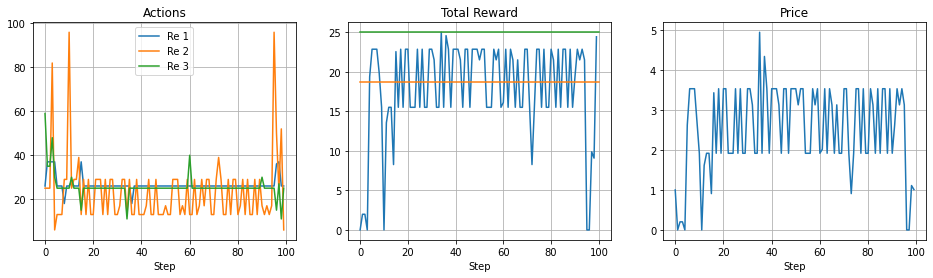

In [120]:
Actions, Rewards, States = [],[],[]
Rewards = []
state = env.reset()
state= np.array([1.])

for e in range(100):
    ep_r = 0    
    # Get probabilities
    States.append(state)
    action = [agent.sample_action(torch.from_numpy(state).float()) for agent in agents]
    action = [a[0].item() for a in action]
    next_state, reward, welfare, done = env.step(action)
    state = next_state
    Actions.append(np.array(action))
    Rewards.append(sum(reward))
    
Actions = np.array(Actions)
Rewards = np.array(Rewards)
States = np.array(States)

f,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(Actions)
ax[1].plot(Rewards)
[n,c] = env.get_optimal()
ax[1].plot((0,len(Rewards)),(n,n))
ax[1].plot((0,len(Rewards)),(c,c))
ax[2].plot(States)
[a.grid() for a in ax]
[a.set_title(c) for a,c in zip(ax, ['Actions','Total Reward', 'Price'])]
[a.set_xlabel('Step') for a in ax]
_=ax[0].legend(['Re 1','Re 2','Re 3'])


In [ ]:
scenarios = np.linspace(0,10,40)
Actions, Rewards = [],[]
for i in range(scenarios.shape[0]):
    action, reward = [],[]
    for j in range(100):
        act = [agent.sample_action(torch.from_numpy(scenarios[[i]]).float()) for agent in agents]
        act = [a[0].item() for a in act]
        env.reset()
        _, r, _, _ = env.step(act)
        action.append(np.array(act))
        reward.append(np.array(r))
    Rewards.append(np.array(reward))
    Actions.append(np.array(action))
Actions = np.array(Actions)
Rewards = np.array(Rewards)

f,ax = plt.subplots(1,2,figsize=(12,5))
mi = np.percentile(Actions,5,axis=1)
ma = np.percentile(Actions,95,axis=1)
ax[0].plot(scenarios, np.mean(Actions,axis=1))
ax[0].fill_between(scenarios, mi[:,0], ma[:,0], alpha=.2)
ax[0].fill_between(scenarios, mi[:,1], ma[:,1], alpha=.2)
ax[0].fill_between(scenarios, mi[:,2], ma[:,2], alpha=.2)
ri = np.percentile(Rewards,5,axis=1)
ra = np.percentile(Rewards,95,axis=1)
ax[1].plot(scenarios, np.mean(Rewards,axis=1))
ax[1].fill_between(scenarios, ri[:,0], ra[:,0], alpha=.2)
ax[1].fill_between(scenarios, ri[:,1], ra[:,1], alpha=.2)
ax[1].fill_between(scenarios, ri[:,2], ra[:,2], alpha=.2)
ax[1].plot(scenarios, np.sum(np.mean(Rewards,axis=1),axis=1))

[a.grid() for a in ax]
[a.set_title(c) for a,c in zip(ax, ['Actions','Rewards'])]
[a.set_xlabel('Price') for a in ax]
ax[0].legend(['Re 1','Re 2','Re 3'])
_=ax[1].legend(['Re 1','Re 2','Re 3','Total'])

## Actor-Critic 


Define Config

In [51]:
config = {'env':'PriceState', 'discrete':True,'nplayers':3, 'nactions':100, 'action_range':[0,1], 'agent':'ActorCritic', 'max_steps':100, 'encoder':'none', 'print_freq':20, 'gamma':Gamma, 'entropy':.0}
env = eval(config['env'])(nactions=config['nactions'], nplayers=config['nplayers'], cost = np.zeros((config['nplayers'])), action_range = config['action_range'], max_steps=config['max_steps'], encoder=config['encoder'])
agents = [eval(config['agent'])(states=env.encode().shape[-1], actions=config['nactions'], gamma=config['gamma'], entropy=config['entropy']) for _ in range(config['nplayers'])]

Train Agents

In [52]:
scores, episodes, t = [], [], time.time()
for e in range(nTtrain):
    done = False
    state = env.reset()
    ep_r = 0    
    while not done:
        # choose actions and step through environment
        action = [agent.sample_action(torch.from_numpy(state).float()) for agent in agents]
        next_state, reward, welfare, done = env.step(action)

        # save transition to the replay memory
        for agent,r,a in zip(agents, reward, action):          
            agent.memory.append(state,a,r,not done,next_state)
        state = next_state
        ep_r += sum(reward)
    scores.append(ep_r)
    episodes.append(e)   
    
    # Train
    [agent.train_net() for agent in agents]

    if not (e%config['print_freq']):
        tr = np.mean(scores[-config['print_freq']:])
        sr = tr/env.max_steps
        print("time:{:2.2f} | episode:{:3d} | mean trajectory reward:{:2.2f} | mean step reward:{:2.2f}".format(time.time()-t,e,tr,sr))
        t = time.time()  


time:0.08 | episode:  0 | mean trajectory reward:323.33 | mean step reward:3.23
time:1.74 | episode: 20 | mean trajectory reward:336.85 | mean step reward:3.37
time:1.64 | episode: 40 | mean trajectory reward:403.69 | mean step reward:4.04
time:1.64 | episode: 60 | mean trajectory reward:501.22 | mean step reward:5.01
time:1.62 | episode: 80 | mean trajectory reward:712.58 | mean step reward:7.13
time:1.64 | episode:100 | mean trajectory reward:976.78 | mean step reward:9.77
time:1.66 | episode:120 | mean trajectory reward:1221.85 | mean step reward:12.22
time:1.65 | episode:140 | mean trajectory reward:1700.68 | mean step reward:17.01
time:1.64 | episode:160 | mean trajectory reward:1960.23 | mean step reward:19.60
time:1.65 | episode:180 | mean trajectory reward:2159.07 | mean step reward:21.59
time:1.66 | episode:200 | mean trajectory reward:2224.48 | mean step reward:22.24
time:1.64 | episode:220 | mean trajectory reward:2321.02 | mean step reward:23.21
time:1.64 | episode:240 | me

Play agents and check decisions

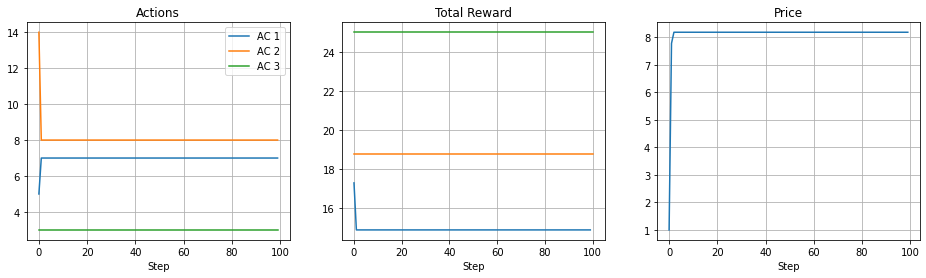

In [48]:
Actions, Rewards, States = [],[],[]
Rewards = []
state = env.reset()
state= np.array([1.])

for e in range(100):
    ep_r = 0    
    # Get probabilities
    States.append(state)
    action = [agent.sample_action(torch.from_numpy(state).float()) for agent in agents]
    next_state, reward, welfare, done = env.step(action)
    state = next_state
    Actions.append(np.array(action))
    Rewards.append(sum(reward))
    
Actions = np.array(Actions)
Rewards = np.array(Rewards)
States = np.array(States)

f,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(Actions)
ax[1].plot(Rewards)
[n,c] = env.get_optimal()
ax[1].plot((0,len(Rewards)),(n,n))
ax[1].plot((0,len(Rewards)),(c,c))
ax[2].plot(States)
[a.grid() for a in ax]
[a.set_title(c) for a,c in zip(ax, ['Actions','Total Reward', 'Price'])]
[a.set_xlabel('Step') for a in ax]
_=ax[0].legend(['AC 1','AC 2','AC 3'])


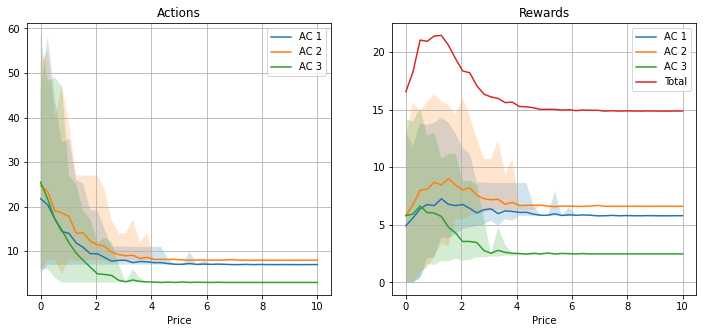

In [49]:
scenarios = np.linspace(0,10,40)
Actions, Rewards = [],[]
for i in range(scenarios.shape[0]):
    action, reward = [],[]
    for j in range(100):
        act = [agent.sample_action(torch.from_numpy(scenarios[[i]]).float()) for agent in agents]
        env.reset()
        _, r, _, _ = env.step(act)
        action.append(np.array(act))
        reward.append(np.array(r))
    Rewards.append(np.array(reward))
    Actions.append(np.array(action))
Actions = np.array(Actions)
Rewards = np.array(Rewards)

f,ax = plt.subplots(1,2,figsize=(12,5))
mi = np.percentile(Actions,5,axis=1)
ma = np.percentile(Actions,95,axis=1)
ax[0].plot(scenarios, np.mean(Actions,axis=1))
ax[0].fill_between(scenarios, mi[:,0], ma[:,0], alpha=.2)
ax[0].fill_between(scenarios, mi[:,1], ma[:,1], alpha=.2)
ax[0].fill_between(scenarios, mi[:,2], ma[:,2], alpha=.2)
ri = np.percentile(Rewards,5,axis=1)
ra = np.percentile(Rewards,95,axis=1)
ax[1].plot(scenarios, np.mean(Rewards,axis=1))
ax[1].fill_between(scenarios, ri[:,0], ra[:,0], alpha=.2)
ax[1].fill_between(scenarios, ri[:,1], ra[:,1], alpha=.2)
ax[1].fill_between(scenarios, ri[:,2], ra[:,2], alpha=.2)
ax[1].plot(scenarios, np.sum(np.mean(Rewards,axis=1),axis=1))

[a.grid() for a in ax]
[a.set_title(c) for a,c in zip(ax, ['Actions','Rewards'])]
[a.set_xlabel('Price') for a in ax]
ax[0].legend(['AC 1','AC 2','AC 3'])
_=ax[1].legend(['AC 1','AC 2','AC 3','Total'])

## Greedy Actor Critic

In [237]:
class GreedyAC():
    def __init__(self, env):
        self.env = env
        self.last_action = 0
        self.collusion_action = 0.5/env.nplayers # Collusion
        self.monopole_action = 0.5               # Monopoly
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward','done', 'new_state'])
        self.memory = ReplayBuffer(1,self.experience)
        
    def sample_action(self, price):
        # Assumes other agents would play the same and he optimizes his action accordingly        
        others = 1-price/env.a-self.last_action
        new_action = np.clip((1-others)/2,self.collusion_action,self.monopole_action)
        self.last_action = new_action
        daction = int(new_action*self.env.nactions)
        return daction
    
    def train_net(self):
        pass
    
config = {'env':'PriceState', 'discrete':True,'nplayers':2, 'nactions':100, 'action_range':[0,1], 'agent':'ActorCritic', 'max_steps':100, 'encoder':'none', 'print_freq':20, 'gamma':Gamma, 'entropy':0.1}
env = eval(config['env'])(nactions=config['nactions'], nplayers=1+config['nplayers'], cost = np.zeros((1+config['nplayers'])), action_range = config['action_range'], max_steps=config['max_steps'], encoder=config['encoder'])
agents = [eval(config['agent'])(states=env.encode().shape[-1], actions=config['nactions'], gamma=config['gamma'], entropy=config['entropy']) for _ in range(config['nplayers'])]
agents.append(GreedyAC(env))
scores, episodes, t = [], [], time.time()
for e in range(nTtrain):
    done = False
    state = env.reset()
    ep_r = 0    
    while not done:
        # choose actions and step through environment
        action = [agent.sample_action(torch.from_numpy(state).float()) for agent in agents]
        next_state, reward, welfare, done = env.step(action)

        # save transition to the replay memory
        for agent,r,a in zip(agents, reward, action):          
            agent.memory.append(state,a,r,not done,next_state)
        state = next_state
        ep_r += sum(reward)
    scores.append(ep_r)
    episodes.append(e)   
    
    # Train
    [agent.train_net() for agent in agents]

    if not (e%config['print_freq']):
        tr = np.mean(scores[-config['print_freq']:])
        sr = tr/env.max_steps
        print("time:{:2.2f} | episode:{:3d} | mean trajectory reward:{:2.2f} | mean step reward:{:2.2f}".format(time.time()-t,e,tr,sr))
        t = time.time() 

time:0.10 | episode:  0 | mean trajectory reward:539.15 | mean step reward:5.39
time:1.95 | episode: 20 | mean trajectory reward:642.63 | mean step reward:6.43
time:1.93 | episode: 40 | mean trajectory reward:833.29 | mean step reward:8.33
time:1.93 | episode: 60 | mean trajectory reward:1033.90 | mean step reward:10.34
time:1.94 | episode: 80 | mean trajectory reward:1299.16 | mean step reward:12.99
time:1.94 | episode:100 | mean trajectory reward:1471.72 | mean step reward:14.72
time:1.95 | episode:120 | mean trajectory reward:1790.17 | mean step reward:17.90
time:1.92 | episode:140 | mean trajectory reward:1940.31 | mean step reward:19.40
time:1.97 | episode:160 | mean trajectory reward:2043.81 | mean step reward:20.44
time:1.92 | episode:180 | mean trajectory reward:2133.48 | mean step reward:21.33
time:1.96 | episode:200 | mean trajectory reward:2208.85 | mean step reward:22.09
time:1.91 | episode:220 | mean trajectory reward:2265.31 | mean step reward:22.65
time:2.00 | episode:24

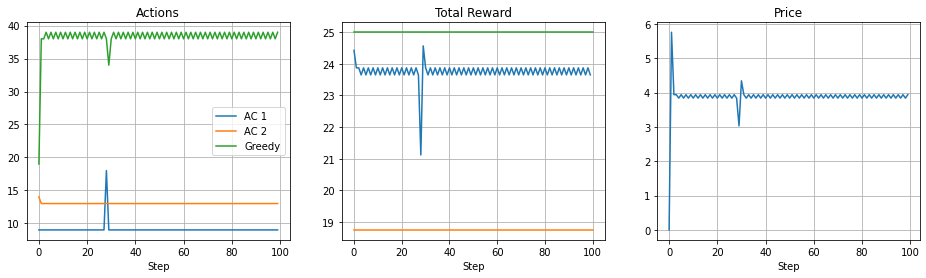

In [238]:
Actions, Rewards, States = [],[],[]
Rewards = []
state = env.reset()
state= np.array([0.])

for e in range(100):
    ep_r = 0    
    # Get probabilities
    States.append(state)
    action = [agent.sample_action(torch.from_numpy(state).float()) for agent in agents]
    next_state, reward, welfare, done = env.step(action)
    state = next_state
    Actions.append(np.array(action))
    Rewards.append(sum(reward))
    
Actions = np.array(Actions)
Rewards = np.array(Rewards)
States = np.array(States)

f,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(Actions)
ax[1].plot(Rewards)
[n,c] = env.get_optimal()
ax[1].plot((0,len(Rewards)),(n,n))
ax[1].plot((0,len(Rewards)),(c,c))
ax[2].plot(States)
[a.grid() for a in ax]
[a.set_title(c) for a,c in zip(ax, ['Actions','Total Reward', 'Price'])]
[a.set_xlabel('Step') for a in ax]
_=ax[0].legend(['AC 1','AC 2','Greedy'])


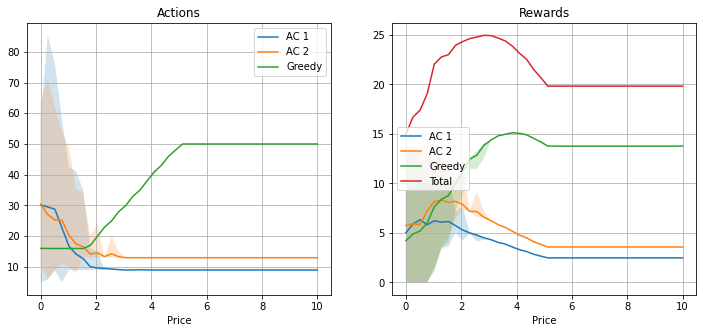

In [239]:
scenarios = np.linspace(0,10,40)
Actions, Rewards = [],[]
for i in range(scenarios.shape[0]):
    action, reward = [],[]
    for j in range(100):
        act = [agent.sample_action(torch.from_numpy(scenarios[[i]]).float()) for agent in agents]
        env.reset()
        _, r, _, _ = env.step(act)
        action.append(np.array(act))
        reward.append(np.array(r))
    Rewards.append(np.array(reward))
    Actions.append(np.array(action))
Actions = np.array(Actions)
Rewards = np.array(Rewards)

f,ax = plt.subplots(1,2,figsize=(12,5))
mi = np.percentile(Actions,5,axis=1)
ma = np.percentile(Actions,95,axis=1)
ax[0].plot(scenarios, np.mean(Actions,axis=1))
ax[0].fill_between(scenarios, mi[:,0], ma[:,0], alpha=.2)
ax[0].fill_between(scenarios, mi[:,1], ma[:,1], alpha=.2)
ax[0].fill_between(scenarios, mi[:,2], ma[:,2], alpha=.2)
ri = np.percentile(Rewards,5,axis=1)
ra = np.percentile(Rewards,95,axis=1)
ax[1].plot(scenarios, np.mean(Rewards,axis=1))
ax[1].fill_between(scenarios, ri[:,0], ra[:,0], alpha=.2)
ax[1].fill_between(scenarios, ri[:,1], ra[:,1], alpha=.2)
ax[1].fill_between(scenarios, ri[:,2], ra[:,2], alpha=.2)
ax[1].plot(scenarios, np.sum(np.mean(Rewards,axis=1),axis=1))

[a.grid() for a in ax]
[a.set_title(c) for a,c in zip(ax, ['Actions','Rewards'])]
[a.set_xlabel('Price') for a in ax]
ax[0].legend(['AC 1','AC 2','Greedy'])
_=ax[1].legend(['AC 1','AC 2','Greedy','Total'])

## SAC - Continouous

In [240]:
config = {'env':'PriceState', 'discrete':False,'nplayers':3, 'nactions':1, 'action_range':[0,1], 'agent':'SAC', 'max_steps':100, 'encoder':'none', 'print_freq':20, 'gamma':Gamma, 'activation':torch.sigmoid}
env = eval(config['env'])(nactions=config['nactions'], nplayers=config['nplayers'], cost = np.zeros((config['nplayers'])), action_range = config['action_range'], max_steps=config['max_steps'], encoder=config['encoder'],discrete=config['discrete'])
agents = [eval(config['agent'])(states=env.encode().shape[-1], actions=config['nactions'], gamma=config['gamma'],activation=config['activation']) for _ in range(config['nplayers'])]


In [241]:
scores, episodes, t = [], [], time.time()
for e in range(nTtrain):
    done = False
    state = env.reset()
    ep_r = 0    
    while not done:
        # choose actions and step through environment
        action = [agent.sample_action(torch.from_numpy(state).float()) for agent in agents]
        next_state, reward, welfare, done = env.step(action)

        # save transition to the replay memory
        for agent,r,a in zip(agents, reward, action):          
            agent.memory.append(state,a,r,not done,next_state)
        state = next_state
        ep_r += sum(reward)

    scores.append(ep_r)
    episodes.append(e)   
    
    # Train
    [agent.train_net() for agent in agents]

    if not (e%config['print_freq']):
        tr = np.mean(scores[-config['print_freq']:])
        sr = tr/env.max_steps
        print("time:{:2.2f} | episode:{:3d} | mean trajectory reward:{:2.2f} | mean step reward:{:2.2f}".format(time.time()-t,e,tr,sr))
        t = time.time()  

time:0.16 | episode:  0 | mean trajectory reward:46.27 | mean step reward:0.46
time:8.67 | episode: 20 | mean trajectory reward:452.98 | mean step reward:4.53
time:13.23 | episode: 40 | mean trajectory reward:98.48 | mean step reward:0.98
time:13.42 | episode: 60 | mean trajectory reward:525.41 | mean step reward:5.25
time:14.82 | episode: 80 | mean trajectory reward:1041.96 | mean step reward:10.42
time:14.14 | episode:100 | mean trajectory reward:1230.07 | mean step reward:12.30
time:13.59 | episode:120 | mean trajectory reward:1130.49 | mean step reward:11.30
time:13.54 | episode:140 | mean trajectory reward:1346.84 | mean step reward:13.47
time:13.61 | episode:160 | mean trajectory reward:2387.45 | mean step reward:23.87
time:13.70 | episode:180 | mean trajectory reward:2357.37 | mean step reward:23.57
time:13.75 | episode:200 | mean trajectory reward:2310.92 | mean step reward:23.11
time:13.77 | episode:220 | mean trajectory reward:2316.14 | mean step reward:23.16
time:14.16 | epi

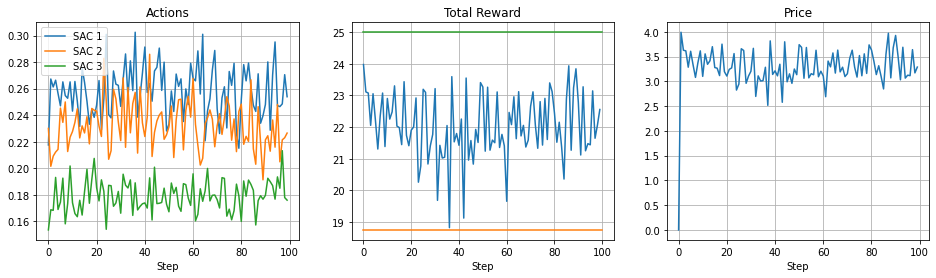

In [242]:
Actions, Rewards, States = [],[],[]
Rewards = []
state = env.reset()
state= np.array([0.])

for e in range(100):
    ep_r = 0    
    # Get probabilities
    States.append(state)
    action = [agent.sample_action(torch.from_numpy(state).float()) for agent in agents]
    next_state, reward, welfare, done = env.step(action)
    state = next_state
    Actions.append(np.array(action))
    Rewards.append(sum(reward))
    
Actions = np.array(Actions)
Rewards = np.array(Rewards)
States = np.array(States)

f,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(Actions)
ax[1].plot(Rewards)
[n,c] = env.get_optimal()
ax[1].plot((0,len(Rewards)),(n,n))
ax[1].plot((0,len(Rewards)),(c,c))
ax[2].plot(States)
[a.grid() for a in ax]
[a.set_title(c) for a,c in zip(ax, ['Actions','Total Reward', 'Price'])]
[a.set_xlabel('Step') for a in ax]
_=ax[0].legend(['SAC 1','SAC 2', 'SAC 3'])

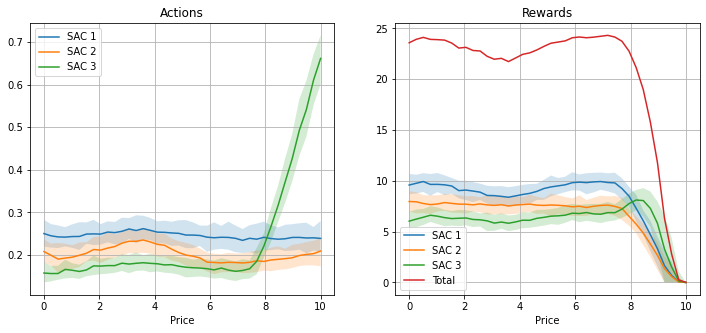

In [243]:
scenarios = np.linspace(0,10,40)
Actions, Rewards = [],[]
for i in range(scenarios.shape[0]):
    action, reward = [],[]
    for j in range(100):
        act = [agent.sample_action(torch.from_numpy(scenarios[[i]]).float()) for agent in agents]
        env.reset()
        _, r, _, _ = env.step(act)
        action.append(np.array(act))
        reward.append(np.array(r))
    Rewards.append(np.array(reward))
    Actions.append(np.array(action))
Actions = np.array(Actions)
Rewards = np.array(Rewards)

f,ax = plt.subplots(1,2,figsize=(12,5))
mi = np.percentile(Actions,5,axis=1)
ma = np.percentile(Actions,95,axis=1)
ax[0].plot(scenarios, np.mean(Actions,axis=1))
ax[0].fill_between(scenarios, mi[:,0], ma[:,0], alpha=.2)
ax[0].fill_between(scenarios, mi[:,1], ma[:,1], alpha=.2)
ax[0].fill_between(scenarios, mi[:,2], ma[:,2], alpha=.2)
ri = np.percentile(Rewards,5,axis=1)
ra = np.percentile(Rewards,95,axis=1)
ax[1].plot(scenarios, np.mean(Rewards,axis=1))
ax[1].fill_between(scenarios, ri[:,0], ra[:,0], alpha=.2)
ax[1].fill_between(scenarios, ri[:,1], ra[:,1], alpha=.2)
ax[1].fill_between(scenarios, ri[:,2], ra[:,2], alpha=.2)
ax[1].plot(scenarios, np.sum(np.mean(Rewards,axis=1),axis=1))

[a.grid() for a in ax]
[a.set_title(c) for a,c in zip(ax, ['Actions','Rewards'])]
[a.set_xlabel('Price') for a in ax]
ax[0].legend(['SAC 1','SAC 2','SAC 3'])
_=ax[1].legend(['SAC 1','SAC 2','SAC 3','Total'])

## Greedy SAC

In [244]:
class GreedySAC():
    def __init__(self, env):
        self.env = env
        self.last_action = 0
        self.collusion_action = 0.5/env.nplayers
        self.monopole_action = 0.5
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward','done', 'new_state'])
        self.memory = ReplayBuffer(1,self.experience)
        
    def sample_action(self, price):
        # Assumes other agents would play the same and he optimizes his action accordingly        
        others = 1-price/self.env.a-self.last_action
        new_action = np.clip((1-others)/2,self.collusion_action,self.monopole_action)
        self.last_action = new_action
        return new_action[0]
    
    def train_net(self):
        pass
         
config = {'env':'PriceState', 'discrete':False,'nplayers':2, 'nactions':1, 'action_range':[0,1], 'agent':'SAC', 'max_steps':100, 'encoder':'none', 'print_freq':20, 'gamma':Gamma, 'activation':torch.sigmoid}
env = eval(config['env'])(nactions=config['nactions'], nplayers=config['nplayers']+1, cost = np.zeros((config['nplayers']+1)), action_range = config['action_range'], max_steps=config['max_steps'], encoder=config['encoder'],discrete=config['discrete'])
agents = [eval(config['agent'])(states=env.encode().shape[-1], actions=config['nactions'], gamma=config['gamma'],activation=config['activation']) for _ in range(config['nplayers'])]
agents.append(GreedySAC(env))
scores, episodes, t = [], [], time.time()

for e in range(nTtrain):
    done = False
    state = env.reset()
    ep_r = 0    
    while not done:
        # choose actions and step through environment
        action = [agent.sample_action(torch.from_numpy(state).float()) for agent in agents]
        next_state, reward, welfare, done = env.step(action)

        # save transition to the replay memory
        for agent,r,a in zip(agents, reward, action):          
            agent.memory.append(state,a,r,not done,next_state)
        state = next_state
        ep_r += sum(reward)

    scores.append(ep_r)
    episodes.append(e)   
    
    # Train
    [agent.train_net() for agent in agents]

    if not (e%config['print_freq']):
        tr = np.mean(scores[-config['print_freq']:])
        sr = tr/env.max_steps
        print("time:{:2.2f} | episode:{:3d} | mean trajectory reward:{:2.2f} | mean step reward:{:2.2f}".format(time.time()-t,e,tr,sr))
        t = time.time()  

time:0.17 | episode:  0 | mean trajectory reward:185.92 | mean step reward:1.86
time:6.65 | episode: 20 | mean trajectory reward:1156.20 | mean step reward:11.56
time:9.61 | episode: 40 | mean trajectory reward:2211.39 | mean step reward:22.11
time:9.62 | episode: 60 | mean trajectory reward:1237.12 | mean step reward:12.37
time:9.77 | episode: 80 | mean trajectory reward:2028.61 | mean step reward:20.29
time:9.85 | episode:100 | mean trajectory reward:2024.02 | mean step reward:20.24
time:10.13 | episode:120 | mean trajectory reward:2004.66 | mean step reward:20.05
time:9.84 | episode:140 | mean trajectory reward:1985.88 | mean step reward:19.86
time:9.87 | episode:160 | mean trajectory reward:1967.54 | mean step reward:19.68
time:11.05 | episode:180 | mean trajectory reward:1951.65 | mean step reward:19.52
time:10.63 | episode:200 | mean trajectory reward:1927.85 | mean step reward:19.28
time:10.09 | episode:220 | mean trajectory reward:1918.18 | mean step reward:19.18
time:10.02 | e

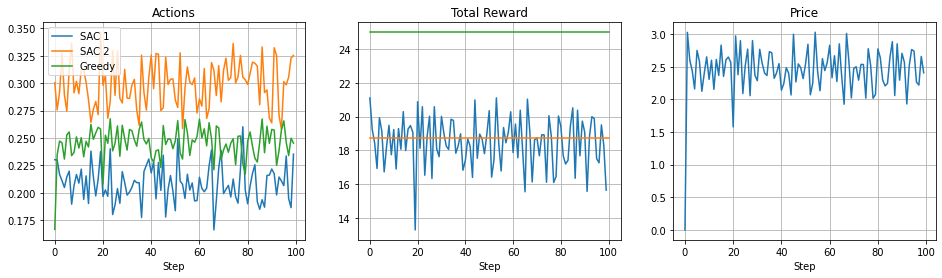

In [245]:
Actions, Rewards, States = [],[],[]
Rewards = []
state = env.reset()
state= np.array([0.])

for e in range(100):
    ep_r = 0    
    # Get probabilities
    States.append(state)
    action = [agent.sample_action(torch.from_numpy(state).float()) for agent in agents]
    next_state, reward, welfare, done = env.step(action)
    state = next_state
    Actions.append(np.array(action))
    Rewards.append(sum(reward))
    
Actions = np.array(Actions)
Rewards = np.array(Rewards)
States = np.array(States)

f,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(Actions)
ax[1].plot(Rewards)
[n,c] = env.get_optimal()
ax[1].plot((0,len(Rewards)),(n,n))
ax[1].plot((0,len(Rewards)),(c,c))
ax[2].plot(States)
[a.grid() for a in ax]
[a.set_title(c) for a,c in zip(ax, ['Actions','Total Reward', 'Price'])]
_=[a.set_xlabel('Step') for a in ax]
ax[0].legend(['SAC 1','SAC 2', 'Greedy'])

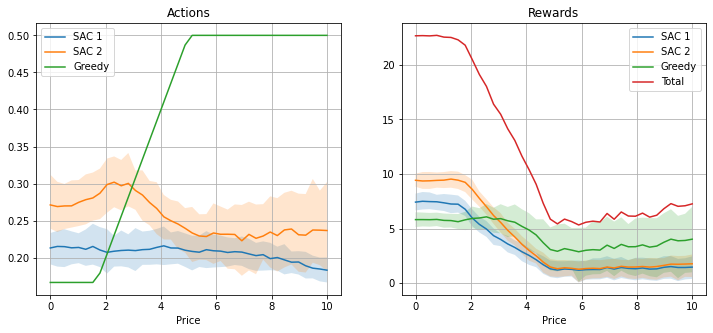

In [246]:
scenarios = np.linspace(0,10,40)
Actions, Rewards = [],[]
for i in range(scenarios.shape[0]):
    action, reward = [],[]
    for j in range(100):
        act = [agent.sample_action(torch.from_numpy(scenarios[[i]]).float()) for agent in agents]
        env.reset()
        _, r, _, _ = env.step(act)
        action.append(np.array(act))
        reward.append(np.array(r))
    Rewards.append(np.array(reward))
    Actions.append(np.array(action))
Actions = np.array(Actions)
Rewards = np.array(Rewards)

f,ax = plt.subplots(1,2,figsize=(12,5))
mi = np.percentile(Actions,5,axis=1)
ma = np.percentile(Actions,95,axis=1)
ax[0].plot(scenarios, np.mean(Actions,axis=1))
ax[0].fill_between(scenarios, mi[:,0], ma[:,0], alpha=.2)
ax[0].fill_between(scenarios, mi[:,1], ma[:,1], alpha=.2)
ax[0].fill_between(scenarios, mi[:,2], ma[:,2], alpha=.2)
ri = np.percentile(Rewards,5,axis=1)
ra = np.percentile(Rewards,95,axis=1)
ax[1].plot(scenarios, np.mean(Rewards,axis=1))
ax[1].fill_between(scenarios, ri[:,0], ra[:,0], alpha=.2)
ax[1].fill_between(scenarios, ri[:,1], ra[:,1], alpha=.2)
ax[1].fill_between(scenarios, ri[:,2], ra[:,2], alpha=.2)
ax[1].plot(scenarios, np.sum(np.mean(Rewards,axis=1),axis=1))

[a.grid() for a in ax]
[a.set_title(c) for a,c in zip(ax, ['Actions','Rewards'])]
[a.set_xlabel('Price') for a in ax]
ax[0].legend(['SAC 1','SAC 2','Greedy'])
_=ax[1].legend(['SAC 1','SAC 2','Greedy','Total'])